# Clean-Label Feature Collision Attacks on a Keras Classifier

In this notebook, we will learn how to use ART to run a clean-label feature collision poisoning attack on a neural network. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/1804.00792) by Shafahi, Huang, et. al. 2018.

In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load Model

In this example, we using a RESNET50 model pretrained on the CIFAR dataset.

In [3]:
path = get_file('cifar_resnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Chose Target Image from test set

true_class: cat
predicted_class: cat


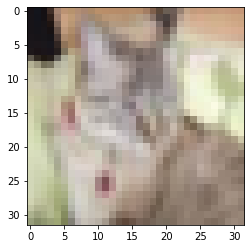

In [4]:
target_class = "cat"
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][1], axis=0)

fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])
# target_instance = x_test[]

feature_layer = classifier.layer_names[-1]

## Poison Training Images to Misclassify Test

The attacker wants to make it such that whenever a prediction is made on this particular cat the output will be a horse.

In [5]:
base_class = "horse"
base_idxs = np.argmax(y_train, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_train[base_idxs][:10])
base_labels = y_train[base_idxs][:10]

# base_instances = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][:10], axis=0)

x_train_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_train_pred == np.argmax(base_labels, axis=1))

print("Original train data (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

Original train data (10 images):
Correctly classified: 10
Incorrectly classified: 0


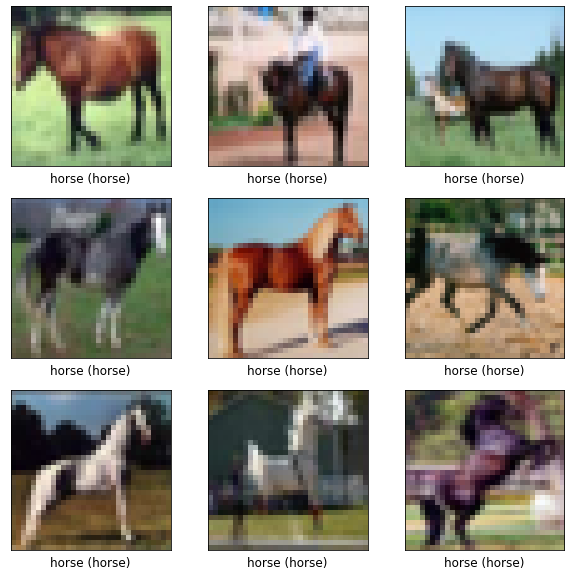

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_train_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

## We create new poison to turn the cat into a horse at test time

In [7]:
feature_layer = classifier.layer_names[-4]
attack = FeatureCollisionAttack(classifier, target_instance, 0.1, feature_layer)
poison = attack.poison(base_instances)

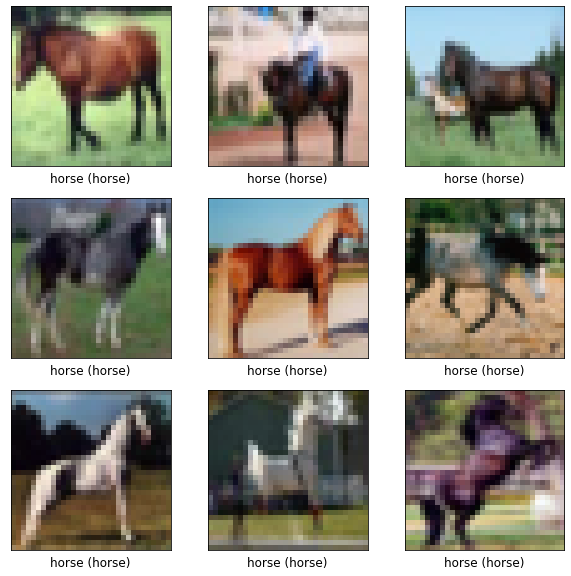

In [8]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

## Train with new poison images

In [9]:
model_layers = classifier._model.layers
i = 0
while (model_layers[i].name != feature_layer):
    # Freeze all layers up to selected feature_layer
    model_layers[i].trainable = False
    i += 1 

classifier.set_learning_phase(True)
# print(classifier._layer_names[-4])
# print(classifier._model.layers[-5].trainable)
print(x_train.shape)
print(base_instances.shape)
adv_train = np.vstack([x_train, base_instances])
adv_labels = np.vstack([y_train, base_labels])
classifier.fit(adv_train, adv_labels, nb_epochs=10, batch_size=128)

(1000, 32, 32, 3)
(10, 32, 32, 3)
Epoch 1/10
7/7 [==============================] - 21s 3s/step - loss: 0.3823 - acc: 0.9308
Epoch 2/10
7/7 [==============================] - 8s 1s/step - loss: 0.3825 - acc: 0.9286
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.3750 - acc: 0.9286
Epoch 4/10
7/7 [==============================] - 8s 1s/step - loss: 0.2683 - acc: 0.9453
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.2956 - acc: 0.9509
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.2672 - acc: 0.9609
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.2301 - acc: 0.9587
Epoch 8/10
7/7 [==============================] - 9s 1s/step - loss: 0.2097 - acc: 0.9643
Epoch 9/10
7/7 [==============================] - 8s 1s/step - loss: 0.2107 - acc: 0.9643
Epoch 10/10
7/7 [==============================] - 8s 1s/step - loss: 0.1747 - acc: 0.9754


## Now my cat is a horse

true_class: cat
predicted_class: cat


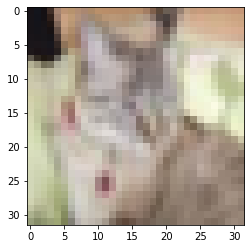

In [10]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

In [11]:
# ## plot images diffs #imperceptible
# poison_pred = np.argmax(classifier.predict(poison), axis=1)
# plt.figure(figsize=(10,10))
# for i in range(0, 9):
#     pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(y_train[i])]
#     plt.subplot(330 + 1 + i)
#     print('max_diff: ' + str(np.max(np.abs(poison[i] - x_train[i]))))
#     fig=plt.imshow(np.abs(poison[i] - x_train[i]))
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
#                   horizontalalignment='center')



In [12]:
poison = base_images
print(base_images.shape)
print('num base images: ' + str(len(base_images)))
target_feature_rep = classifier.get_activations(target, feature_layer, 1, intermediate=True)
poison_feature_rep = classifier.get_activations(poison, feature_layer, 1, intermediate=True)
print('feature rep type: ' + str(poison_feature_rep))

attack_loss = classifier.normalize_tensor(poison_feature_rep - target_feature_rep)
print('attack_loss input shape: ' +  str(attack_loss))

print('attack loss type: ' + str(type(attack_loss)))
attack_grad = classifier.custom_gradient(attack_loss, classifier.get_input_layer(), poison)

NameError: name 'base_images' is not defined

In [ ]:
plt.imshow(poison[0])